# Data initial exploration 
*Matthieu OLEKHNOVITCH*

## Introduction 
This notebook is dedicated to the initial exploration of the data. It is the first step of the data science process. The goal is to get a first idea of the data, to understand it and to identify the main challenges.

In [2]:
import numpy as np
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

In [158]:
# ----------------- Load Training Labels -----------------#

training_label_path = 'training_labels.json'
print(os.path.dirname(os.path.abspath(training_label_path)))
try :
    data = json.load(open(training_label_path))
except FileNotFoundError:
    print('File not found: ', training_label_path)

print(training_label_path + ' loaded')

# ----------------- Load Training Data -------------------#

training_data_path = 'training/'
discussion_ids = []
for key in data.keys():
    discussion_ids.append(key)

print('Number of discussions: ', len(discussion_ids))

# -------------------------------------------------------#

d:\Github\Kaggle-competition---Extractive-Summarization-with-Discourse-Graphs
training_labels.json loaded
Number of discussions:  97


# Building a conversation graph (visualization)

In [159]:
# ------------------- Load Discussions ------------------#  

discussion_id = discussion_ids[0]                                  # Select a discussion

print('Discussion ID: ', discussion_id)
discussion_path = training_data_path + discussion_id + '.json'
try :
    discussion_json = json.load(open(discussion_path))
    print('Discussion file loaded')
except: 
    print('Error loading discussion file')

num_of_posts = len(discussion_json)
print('Number of posts: ', num_of_posts)

# ---------------------- Load edges ----------------------#

edges_path = training_data_path + discussion_id + '.txt'
edges = np.array(np.loadtxt(edges_path, dtype=str))
print('Number of edges: ', len(edges))



Discussion ID:  IS1003d
Discussion file loaded
Number of posts:  1095
Number of edges:  1094


change type of edge

In [162]:
#select unique types
types = []
for i in range(len(edges)):
    types.append(edges[i, 1])
types = np.unique(types)

#associate a number to each type
types_dict = {}
for i in range(len(types)):
    types_dict[types[i]] = i

#create the new edges
# Replace edges[i, 1] with the number associated with each type using types_dict
formatted_edges = np.array([[u, int(types_dict[old_type]), v] for u, old_type, v in edges])


edges = formatted_edges

In [163]:
print(edges)

[['0' '3' '1']
 ['1' '14' '2']
 ['1' '4' '3']
 ...
 ['1091' '0' '1092']
 ['1092' '6' '1093']
 ['1091' '3' '1094']]


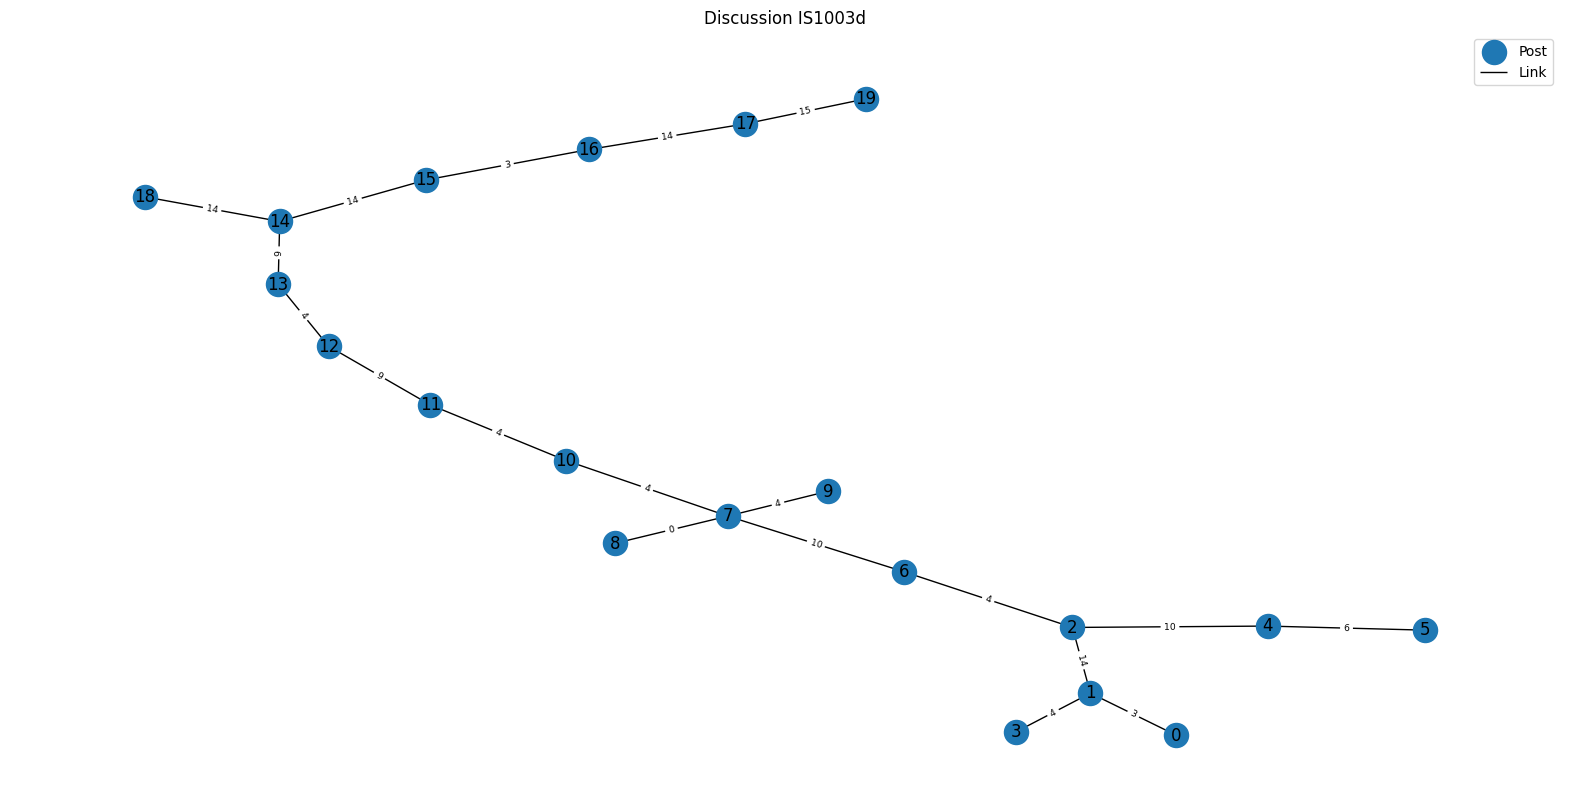

In [164]:
plt.figure(figsize=(20, 10))
plt.title('Discussion ' + discussion_id)
G = nx.Graph()
## Add nodes with labels
G.add_nodes_from(range(num_of_posts))
for i in range(num_of_posts):
    G.nodes[i]['text'] = discussion_json[i]['text']
for i in range(len(edges)):
    G.add_edge(int(edges[i, 0]), int(edges[i, 2]), type= edges[i, 1])

k = 20
G2 = G.subgraph(range(k)).copy()
pos = nx.spring_layout(G2)            
nx.draw(G2, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(G2,'type')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels,font_size=30/np.sqrt(k))
plt.legend(labels=['Post', 'Link'])
plt.show()

In [8]:
import torch
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import gensim

changer graph en tenseur


In [ ]:
import embedding as bd
bd.load_embedding_model()

In [165]:



def nx_to_pyg(G):
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    x = [bd.get_sentence_embedding(G.nodes[i]['text']) for i in G.nodes]
    x = torch.tensor(x, dtype=torch.float32)
    edge_attr = [G[i][j]['type'] for i, j in G.edges]
    edge_attr = torch.tensor(edge_attr, dtype=torch.float32).view(-1, 1)
    
    data_ = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data_

# Exemple d'utilisation
pyg_data = nx_to_pyg(G)


ValueError: too many dimensions 'str'

Model GNN

In [51]:





class GNNModel(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    
your_num_features = 300
num_epochs = 10


# Extract labels for a specific identifier (e.g., "IS1003d")
identifier = "IS1003d"
your_ground_truth_labels = torch.tensor(data.get(identifier, []), dtype=torch.long)

    
your_loss_function = nn.CrossEntropyLoss()
your_ground_truth_labels = torch.tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 0])

#transofm training_label into list
training_label_list = []
for key in data.keys():
    training_label_list.append(data[key])
    

# Exemple d'utilisation
model = GNNModel(num_features=your_num_features, hidden_dim=64, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entraînement
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(pyg_data)
    loss = your_loss_function(output, your_ground_truth_labels)
    loss.backward()
    optimizer.step()

# Évaluation
model.eval()
with torch.no_grad():
    output = model(pyg_data)
    predicted_labels = output.argmax(dim=1)
    # Évaluez la performance du modèle selon vos critères

ValueError: Expected input batch_size (1095) to match target batch_size (10).

In [90]:
print(data)

{'type': 'Continuation'}
